In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from collections import defaultdict
#from Solver import solver
#import Solver_V2
import Solver_V3
import utilities as util

# Lectura de Datos

In [2]:
df = pd.read_csv("datos_arreglados.csv", encoding="latin1")
df = df[df["ID"] > 60] #esto pues las primeras filas estaban falladas

In [3]:
#df.rename(columns={'Ethical technology assessment?':'Ethical technology assessment'}, inplace=True)

bach = df[df['program'] == 'bachelor'] #selecciona las tuplas de bachelor en un df
mast = df[df['program'] == 'master'] #selecciona las tuplas master en un df

b_aal = bach[bach['campus'] == 'AAL'] #selecciona las tuplas bachelor aal en df
m_aal = mast[mast['campus'] == 'AAL'] #selecciona las tuplas master aal en df

b_cph = bach[bach['campus'] == 'CPH'] #selecciona las tuplas bachelor cph en df
m_cph = mast[mast['campus'] == 'CPH'] #selecciona las tuplas master cph en df

esb = df[df['campus'] == 'ESB'] #selecciona las tuplas esb en df

In [4]:
col1 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most4' 
col2 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most5'
col3 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most6'

cursos_b_aal = sorted(set(b_aal[col1]) | set(b_aal[col2]) | set(b_aal[col3])) #talleres disponibles para bachelor aal, en base a los seleccionados en top 3
cursos_m_aal = sorted(set(m_aal[col1]) | set(m_aal[col2]) | set(m_aal[col3])) #talleres disponibles para master aal,  en base a los seleccionados en top 3

cursos_b_cph = sorted(set(b_cph[col1]) | set(b_cph[col2]) | set(b_cph[col3])) #talleres disponibles para bachelor cph, en base a los seleccionados en top 3
cursos_m_cph = sorted(set(m_cph[col1]) | set(m_cph[col2]) | set(m_cph[col3])) #talleres disponibles para master cph,  en base a los seleccionados en top 3

cursos_esb = sorted(set(esb[col1]) | set(esb[col2]) | set(esb[col3])) #talleres disponibles para esb, en base a los seleccionados en top 3


#selecciona columnas de los nombres de curso, donde cada columna posee NaN, 1, 2, 3 indicando preferencia top 3 o no
pref_b_aal = b_aal[cursos_b_aal] 
pref_m_aal = m_aal[cursos_m_aal] 

pref_b_cph = b_cph[cursos_b_cph]
pref_m_cph = m_cph[cursos_m_cph]

pref_esb = esb[cursos_esb]

In [5]:
pref_esb.head()

,Clarification of individual professional competences,Collaboration across discplines,Creativity and entrepeneurship,Digital and hybrid practices in collaborative work,Digital practices in project work,Ethical technology assessment,Facilitation of productive meeting,Generative AI in study practices?,Interdisciplinary problem design,Leadership and project management,"Motivation, well-being and work-life balance?",Professional communication with external partners,Professional identity development,Psychological safety in team work,Psychological safety in teamwork,SCRUM-techniques in project work?,Systems thinking in engineering
11,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN
16,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0


Establecer preferencias de estudiantes

In [6]:
#ejemplo:
util.get_dict(pref_m_aal, 1)                     # Para saber preferencia de estudiante 
                                                 # s en opcion i. se aplica t_pref[s][i]

{1: 1, 2: 5, 3: 2}

# Implementación

In [7]:
# Elegir Programa y campus
pref = pref_m_aal

# Setear Parámetros
(S, T, H, C, U, t_pref, D, p) = util.get_par(pref)

D[1] = 1                                # el taller 1 es de día completo
C = [6, 6]                              # capacidad de talleres por horario (AM, PM)
U = [70 for _ in range(pref.shape[1])]  # capacidad de cada taller (todos con 80 cupos)

pref.head()

,Clarification of individual professional competences,Creative and systems thinking for complex problem-solving (whole day workshop - you are then attending 1 workshop the whole day),Digital and hybrid practices in collaborative work,Ethical technology assessment,Leadership and project management,Professional communication with external partners,Professional identity development,Psychological safety in team work
13,1.0,3.0,NaN,NaN,NaN,NaN,2.0,NaN
15,NaN,1.0,3.0,NaN,NaN,2.0,NaN,NaN
20,1.0,NaN,NaN,3.0,NaN,NaN,2.0,NaN
21,1.0,NaN,NaN,3.0,NaN,NaN,2.0,NaN
24,3.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN


In [8]:
%%time
# 0 al final para que no hable tanto, 1 si quiero más infor
#modelo, y, z, w = solver(S, T, H, C, U, t_pref, D, p, 0)
modelo, y, z, w = Solver_V3.solver(S, T, H, C, U, t_pref, D, p, 1) 

Set parameter Username
Academic license - for non-commercial use only - expires 2026-10-16
Set parameter TimeLimit to value 1800
Set parameter OutputFlag to value 1
Set parameter Seed to value 69420
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800
Seed  69420

Optimize a model with 10252 rows, 6336 columns and 37824 nonzeros
Model fingerprint: 0x986629cc
Model has 786 quadratic constraints
Variable types: 0 continuous, 6336 integer (6336 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
  QRHS range       [1e+00, 1e+00]
Presolve removed 788 rows and 4 columns
Presolve time: 0.36s
Presolved: 

In [51]:
#si es infactible, ver la razón
"""
if model.status == GRB.INFEASIBLE:
    print("Modelo es infeasible. Buscando IIS...")
    
    # Computar IIS
    model.computeIIS()
    
    # Mostrar restricciones y variables en conflicto
    print("\nRestricciones en conflicto:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(c.ConstrName)
    
    print("\nVariables involucradas en conflicto:")
    for v in model.getVars():
        if v.IISLB or v.IISUB:
            print(v.VarName)
"""

'\nif model.status == GRB.INFEASIBLE:\n    print("Modelo es infeasible. Buscando IIS...")\n\n    # Computar IIS\n    model.computeIIS()\n\n    # Mostrar restricciones y variables en conflicto\n    print("\nRestricciones en conflicto:")\n    for c in model.getConstrs():\n        if c.IISConstr:\n            print(c.ConstrName)\n\n    print("\nVariables involucradas en conflicto:")\n    for v in model.getVars():\n        if v.IISLB or v.IISUB:\n            print(v.VarName)\n'

# Resultados

In [9]:
# En promedio, puntaje por alumno
modelo.ObjVal / (len(S) - 1)

13.520408163265307

In [27]:
#restricciones y variables
print(f"{modelo.NumConstrs} son restricciones lineales")
print(f"{modelo.NumQConstrs} son restricciones cuadraticas")
print(f"{modelo.NumGenConstrs} son restricciones generales")
print(f"{modelo.NumVars} variables")

10252 son restricciones lineales
786 son restricciones cuadraticas
0 son restricciones generales
6336 variables


In [10]:
util.ver_talleres(z)

El taller 0 fue elegido para realizarse
El taller 1 no se realizará
El taller 2 fue elegido para realizarse
El taller 3 fue elegido para realizarse
El taller 4 fue elegido para realizarse
El taller 5 fue elegido para realizarse
El taller 6 fue elegido para realizarse
El taller 7 fue elegido para realizarse
El taller 8 fue elegido para realizarse
El taller 9 fue elegido para realizarse
El taller 10 no se realizará
El taller 11 no se realizará
El taller 12 fue elegido para realizarse
El taller 13 no se realizará
El taller 14 fue elegido para realizarse
El taller 15 no se realizará


In [11]:
util.ver_talleres_mod(z, len(T))

El taller 0.0 fue elegido para realizarse
El taller 1.0 no se realizará
El taller 2.0 fue elegido para realizarse
El taller 3.0 fue elegido para realizarse
El taller 4.0 fue elegido para realizarse
El taller 5.0 fue elegido para realizarse
El taller 6.0 fue elegido para realizarse
El taller 7.0 fue elegido para realizarse
El taller 0.1 fue elegido para realizarse
El taller 1.1 fue elegido para realizarse
El taller 2.1 no se realizará
El taller 3.1 no se realizará
El taller 4.1 fue elegido para realizarse
El taller 5.1 no se realizará
El taller 6.1 fue elegido para realizarse
El taller 7.1 no se realizará


In [12]:
talleres_AM, talleres_PM = util.talleres_horarios(y)

El taller 0 se da en el horario AM
El taller 2 se da en el horario PM
El taller 3 se da en el horario AM
El taller 4 se da en el horario PM
El taller 5 se da en el horario AM
El taller 6 se da en el horario AM
El taller 7 se da en el horario PM
El taller 8 se da en el horario PM
El taller 9 se da en el horario AM
El taller 9 se da en el horario PM
El taller 12 se da en el horario AM
El taller 14 se da en el horario PM


In [13]:
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i))

Talleres AM
- Taller 0
- Taller 3
- Taller 5
- Taller 6
- Taller 9
- Taller 12
Talleres PM
- Taller 2
- Taller 4
- Taller 7
- Taller 8
- Taller 9
- Taller 14


In [14]:
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i%(len(T))) + "." + str(i//(len(T))))

Talleres AM
- Taller 0.0
- Taller 3.0
- Taller 5.0
- Taller 6.0
- Taller 1.1
- Taller 4.1
Talleres PM
- Taller 2.0
- Taller 4.0
- Taller 7.0
- Taller 0.1
- Taller 1.1
- Taller 6.1


In [15]:
dic_asignaciones_realizadas = util.ver_asignaciones(w)

El estudiante 0 fue asignado al taller 6
El estudiante 0 fue asignado al taller 8
El estudiante 1 fue asignado al taller 2
El estudiante 1 fue asignado al taller 5
El estudiante 2 fue asignado al taller 0
El estudiante 2 fue asignado al taller 14
El estudiante 3 fue asignado al taller 0
El estudiante 3 fue asignado al taller 14
El estudiante 4 fue asignado al taller 2
El estudiante 4 fue asignado al taller 12
El estudiante 5 fue asignado al taller 2
El estudiante 5 fue asignado al taller 5
El estudiante 6 fue asignado al taller 9
El estudiante 7 fue asignado al taller 9
El estudiante 8 fue asignado al taller 5
El estudiante 8 fue asignado al taller 8
El estudiante 9 fue asignado al taller 3
El estudiante 9 fue asignado al taller 7
El estudiante 10 fue asignado al taller 3
El estudiante 10 fue asignado al taller 7
El estudiante 11 fue asignado al taller 9
El estudiante 12 fue asignado al taller 3
El estudiante 12 fue asignado al taller 7
El estudiante 13 fue asignado al taller 9
El estu

In [16]:
#este diccionario es importante pues indica a la versión del taller al que fue asignado (v1 o v2, y con esto se ve el horario)
print(dic_asignaciones_realizadas) #key: estudiante, value:[talleres asignados]

{0: [6, 8], 1: [2, 5], 2: [0, 14], 3: [0, 14], 4: [2, 12], 5: [2, 5], 6: [9], 7: [9], 8: [5, 8], 9: [3, 7], 10: [3, 7], 11: [9], 12: [3, 7], 13: [9], 14: [3, 4], 15: [7, 12], 16: [0, 4], 17: [4, 6], 18: [8, 12], 19: [6, 7], 20: [7, 12], 21: [4, 6], 22: [0, 14], 23: [12, 14], 24: [2, 3], 25: [9], 26: [5, 14], 27: [9], 28: [5, 8], 29: [5, 8], 30: [5, 8], 31: [5, 8], 32: [3, 8], 33: [0, 4], 34: [7, 12], 35: [7, 12], 36: [8, 12], 37: [0, 14], 38: [5, 8], 39: [5, 8], 40: [8, 12], 41: [9], 42: [4, 5], 43: [0, 4], 44: [0, 14], 45: [2, 6], 46: [2, 12], 47: [6, 8], 48: [6, 8], 49: [6, 7], 50: [0, 14], 51: [6, 8], 52: [5, 14], 53: [0, 14], 54: [3, 7], 55: [5, 14], 56: [0, 14], 57: [7, 12], 58: [9], 59: [6, 8], 60: [9], 61: [4, 6], 62: [9], 63: [2, 6], 64: [2, 12], 65: [5, 8], 66: [12, 14], 67: [6, 8], 68: [5, 8], 69: [2, 5], 70: [12, 14], 71: [5, 8], 72: [4, 6], 73: [9], 74: [9], 75: [2, 6], 76: [2, 12], 77: [2, 6], 78: [9], 79: [8, 12], 80: [12, 14], 81: [2, 6], 82: [4, 6], 83: [9], 84: [5, 14]

In [17]:
n_talleres = len(T)
dic_asignaciones_realizadas_mod = {k: [x%n_talleres for x in v] for k, v in dic_asignaciones_realizadas.items()}

In [18]:
#Todos deben ser iguales, es decir, todos los estudiantes fueron asignados a talleres
print(len(S))
print(len(dic_asignaciones_realizadas))
print(len(dic_asignaciones_realizadas_mod))

393
393
393


In [19]:
#este diccionario considera el taller independiente de si lo da en cualquiera de las x versiones de este
print(dic_asignaciones_realizadas_mod)

{0: [6, 0], 1: [2, 5], 2: [0, 6], 3: [0, 6], 4: [2, 4], 5: [2, 5], 6: [1], 7: [1], 8: [5, 0], 9: [3, 7], 10: [3, 7], 11: [1], 12: [3, 7], 13: [1], 14: [3, 4], 15: [7, 4], 16: [0, 4], 17: [4, 6], 18: [0, 4], 19: [6, 7], 20: [7, 4], 21: [4, 6], 22: [0, 6], 23: [4, 6], 24: [2, 3], 25: [1], 26: [5, 6], 27: [1], 28: [5, 0], 29: [5, 0], 30: [5, 0], 31: [5, 0], 32: [3, 0], 33: [0, 4], 34: [7, 4], 35: [7, 4], 36: [0, 4], 37: [0, 6], 38: [5, 0], 39: [5, 0], 40: [0, 4], 41: [1], 42: [4, 5], 43: [0, 4], 44: [0, 6], 45: [2, 6], 46: [2, 4], 47: [6, 0], 48: [6, 0], 49: [6, 7], 50: [0, 6], 51: [6, 0], 52: [5, 6], 53: [0, 6], 54: [3, 7], 55: [5, 6], 56: [0, 6], 57: [7, 4], 58: [1], 59: [6, 0], 60: [1], 61: [4, 6], 62: [1], 63: [2, 6], 64: [2, 4], 65: [5, 0], 66: [4, 6], 67: [6, 0], 68: [5, 0], 69: [2, 5], 70: [4, 6], 71: [5, 0], 72: [4, 6], 73: [1], 74: [1], 75: [2, 6], 76: [2, 4], 77: [2, 6], 78: [1], 79: [0, 4], 80: [4, 6], 81: [2, 6], 82: [4, 6], 83: [1], 84: [5, 6], 85: [3, 6], 86: [4, 6], 87: [4,

# Estadísticas

In [44]:
#este no considera dobles versiones (ej: si quería el taller 0 y se le asignó al taller 8 (que es el 0 en su segunda versión))
contador_primera_opt = 0
contador_segunda_opt = 0
contador_tercera_opt = 0

for s in range(len(S)):
    if t_pref[s][1] in dic_asignaciones_realizadas[s]:
        contador_primera_opt += 1
    if t_pref[s][2] in dic_asignaciones_realizadas[s]:
        contador_segunda_opt += 1
    if t_pref[s][3] in dic_asignaciones_realizadas[s]:
        contador_tercera_opt += 1

print(contador_primera_opt)
print(contador_segunda_opt)
print(contador_tercera_opt)

182
183
66


In [24]:
#este sí considera dobles versiones para contabilizar
contador_primera_opt = 0 #quedó en top 1 y la otra no quería
contador_segunda_opt = 0 #quedó en top 2 y la otra no quería
contador_tercera_opt = 0 #quedó en top 3 y la otra no quería
contador_primera_segunda_opt = 0 #quedó en top 1 y top2
contador_segunda_tercera_opt = 0 #quedó en top 2 y top 3
contador_primera_tercera_opt = 0 #quedó en top 1 y top 3
contador_ninguna = 0 #no quedó en ninguna que quería
contador_primera_opt_whole_day = 0 #quedó en top 1 y era taller de solo un día
contador_segunda_opt_whole_day = 0 #quedó en top 2 y era taller de solo un día
contador_tercera_opt_whole_day = 0 #quedó en top 3 y era taller de solo un día

for s in range(len(S)):
    if (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_segunda_opt += 1 #quedó en top 1 y top2
    elif (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_segunda_tercera_opt += 1 #quedó en top 2 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]):
        contador_primera_tercera_opt += 1 #quedó en top 1 y top 3
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_primera_opt += 1 #quedó en top 1 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_segunda_opt += 1 #quedó en top 2 y la otra no quería
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) != 1):
        contador_tercera_opt += 1 #quedó en top 3 y la otra no quería
    elif (t_pref[s][1] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_primera_opt_whole_day += 1 #quedó en top 1 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] not in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_segunda_opt_whole_day += 1 #quedó en top 2 y era todo el dia
    elif (t_pref[s][1] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][2] not in dic_asignaciones_realizadas_mod[s]) and (t_pref[s][3] in dic_asignaciones_realizadas_mod[s]) and (len(dic_asignaciones_realizadas_mod[s]) == 1):
        contador_tercera_opt_whole_day += 1 #quedó en top 3 y era todo el dia
    else:
        contador_ninguna += 1 #no quedó en ninguna que quería
        print(dic_asignaciones_realizadas_mod[s])
        print(t_pref[s])

n_alumnos = len(t_pref)

print(f"Hay {contador_primera_opt} solo en su primera opción, un {100*contador_primera_opt/n_alumnos}%")
print(f"Hay {contador_segunda_opt} solo en su segunda opción, un {100*contador_segunda_opt/n_alumnos}%")
print(f"Hay {contador_tercera_opt} solo en su tercera opción, un {100*contador_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_segunda_opt} en su primera y segunda opción, un {100*contador_primera_segunda_opt/n_alumnos}%")
print(f"Hay {contador_segunda_tercera_opt} en su segunda y tercera opción, un {100*contador_segunda_tercera_opt/n_alumnos}%")
print(f"Hay {contador_primera_tercera_opt} en su primera y tercera opción, un {100*contador_primera_tercera_opt/n_alumnos}%")
print(f"Hay {contador_ninguna} en nada que eligió :(, un {100*contador_ninguna/n_alumnos}%")
print(f"Hay {contador_primera_opt_whole_day} solo en su primera opcion, pero esta era de día completo, un {100*contador_primera_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_segunda_opt_whole_day} solo en su segunda opción, pero esta era de día completo, un {100*contador_segunda_opt_whole_day/n_alumnos}%")
print(f"Hay {contador_tercera_opt_whole_day} solo en su tercera opción, pero esta era de día completo, un {100*contador_tercera_opt_whole_day/n_alumnos}%")


Hay 4 solo en su primera opción, un 1.0178117048346056%
Hay 1 solo en su segunda opción, un 0.2544529262086514%
Hay 0 solo en su tercera opción, un 0.0%
Hay 243 en su primera y segunda opción, un 61.83206106870229%
Hay 13 en su segunda y tercera opción, un 3.3078880407124682%
Hay 62 en su primera y tercera opción, un 15.776081424936386%
Hay 0 en nada que eligió :(, un 0.0%
Hay 70 solo en su primera opcion, pero esta era de día completo, un 17.8117048346056%
Hay 0 solo en su segunda opción, pero esta era de día completo, un 0.0%
Hay 0 solo en su tercera opción, pero esta era de día completo, un 0.0%


In [41]:
#contar cuantos quedaron solo en lo que pidieron
contador_suertudo = 0
contador_no = 0
contador = 0

for s in range(len(S)):
    asignados = dic_asignaciones_realizadas_mod[s]  
    prefs_vals = set(t_pref[s].values())     

    #todos los asignados están entre los valores preferidos
    if all(a in prefs_vals for a in asignados):
        contador_suertudo += 1
    else:
        contador_no += 1
        print(s, prefs_vals, asignados)
    contador += 1

print("Total suertudos:", contador_suertudo, contador_suertudo/n_alumnos)
print(f"hay {contador_no} estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el {contador_no/n_alumnos} de 1")
print(contador)

200 {0, 1, 5} [2, 5]
213 {0, 1, 3} [3, 7]
226 {1, 3, 4} [2, 3]
255 {1, 4, 5} [2, 5]
261 {1, 3, 5} [2, 3]
Total suertudos: 388 0.9872773536895675
hay 5 estudiantes que quedaron en algo que no pidieron (al menos 1 taller), esto es el 0.01272264631043257 de 1
393


In [42]:
print(contador_suertudo+contador_no)

393


In [84]:
for key, value in dic_asignaciones_realizadas.items():
    if len(value) != 2:
        print(f"Al estudiante {key} se le asignó taller(es) {value}, verificar si es taller de 1 día completo o fallo")

Al estudiante 1 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 7 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 11 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 13 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 41 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 58 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 60 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 62 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 73 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 74 se le asignó taller(es) [9], verificar si es taller de 1 día completo o fallo
Al estudiante 96 se le asignó taller(es) [9], verifi

El taller 0 tiene 69 alumnos, está un 98.57142857142858% lleno
El taller 2 tiene 57 alumnos, está un 81.42857142857143% lleno
El taller 4 tiene 70 alumnos, está un 100.0% lleno
El taller 6 tiene 70 alumnos, está un 100.0% lleno
El taller 8 tiene 70 alumnos, está un 100.0% lleno
El taller 9 tiene 70 alumnos, está un 100.0% lleno
El taller 11 tiene 43 alumnos, está un 61.42857142857143% lleno
El taller 12 tiene 70 alumnos, está un 100.0% lleno
El taller 13 tiene 70 alumnos, está un 100.0% lleno
El taller 14 tiene 69 alumnos, está un 98.57142857142858% lleno
El taller 15 tiene 56 alumnos, está un 80.0% lleno


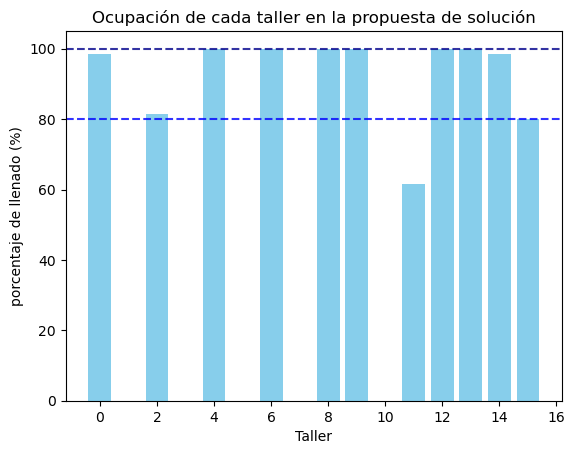

In [85]:
#contar cuanto se llenó cada taller
talleres = []
porcentajes = []
U_2 = U + U
capacidad_real_taller = defaultdict(int) #la key es el id del taller 0, 1,... y el value es la cantidad de alumnos asignados a este taller en la solución
for key, value in dic_asignaciones_realizadas.items():
    for taller in value:
       capacidad_real_taller[taller] += 1 

for taller, cantidad in sorted(capacidad_real_taller.items()):
    porcentaje = 100 * cantidad / U_2[taller]
    talleres.append(taller)
    porcentajes.append(porcentaje)
    print(f"El taller {taller} tiene {cantidad} alumnos, está un {100*(cantidad/U_2[taller])}% lleno")

plt.bar(talleres, porcentajes, color='skyblue')
plt.ylabel('porcentaje de llenado (%)')
plt.xlabel('Taller')
plt.title('Ocupación de cada taller en la propuesta de solución')
plt.axhline(100, color='darkblue', linestyle='--', linewidth=1.5, label='100%', alpha=0.8)
plt.axhline(80, color='blue', linestyle='--', linewidth=1.5, label='80%', alpha=0.8)

In [86]:
suma_AM = 0
suma_PM = 0
for taller in talleres_AM:
    suma_AM += capacidad_real_taller[taller]
for taller in talleres_PM:
    suma_PM += capacidad_real_taller[taller]
print(suma_AM)
print(suma_PM)

392
392


### Visualizar algunas asignaciones de talleres vs lo que eligió

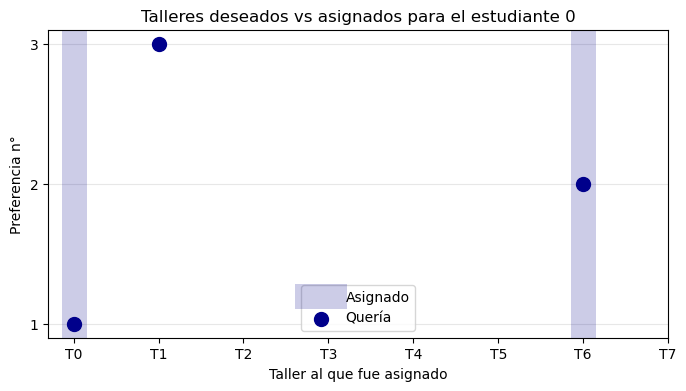

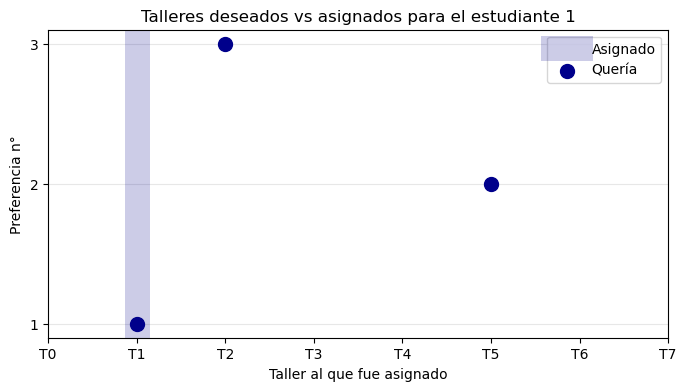

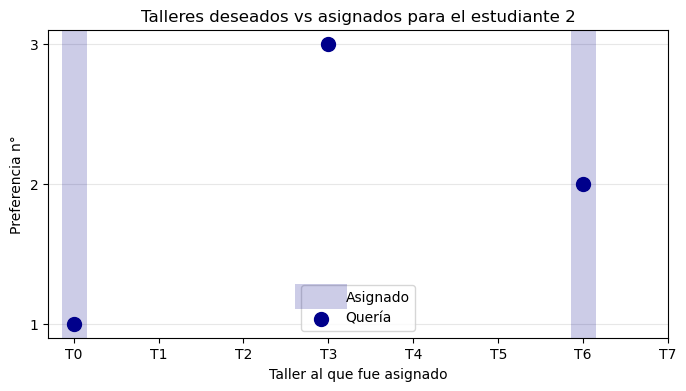

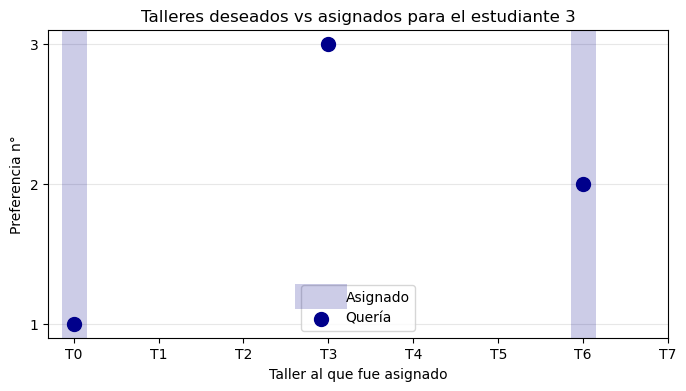

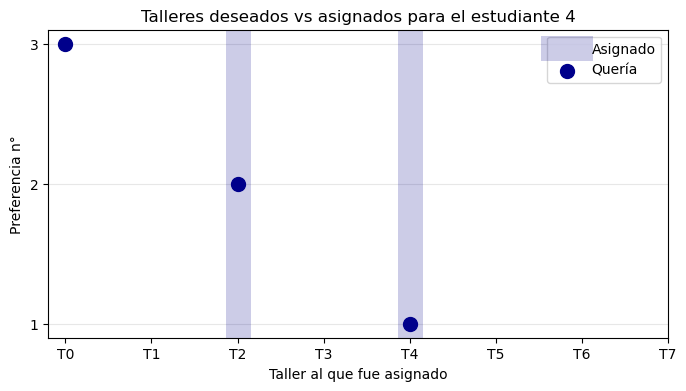

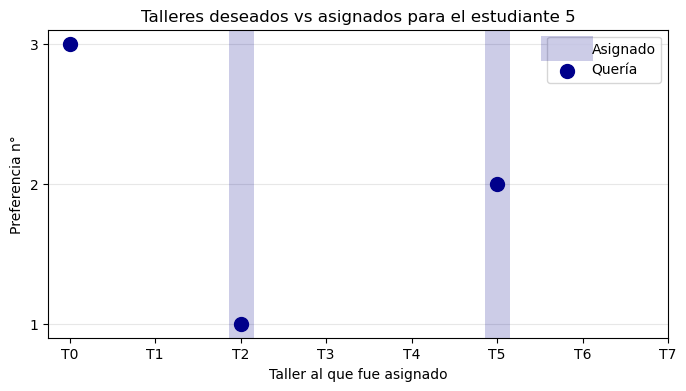

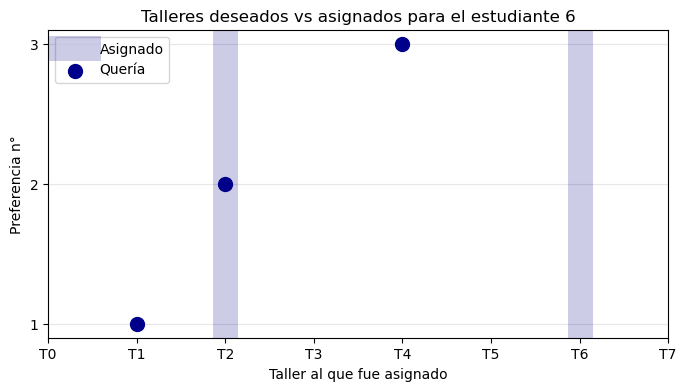

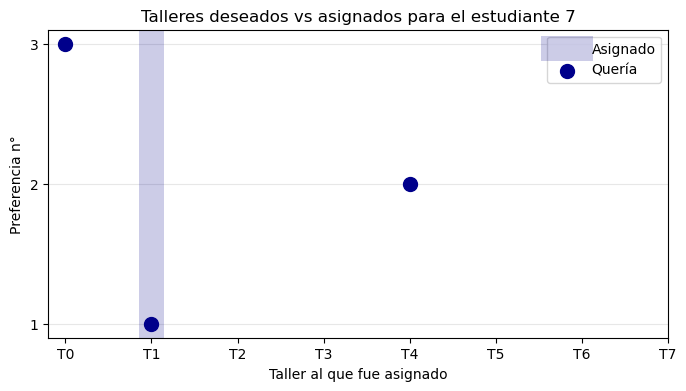

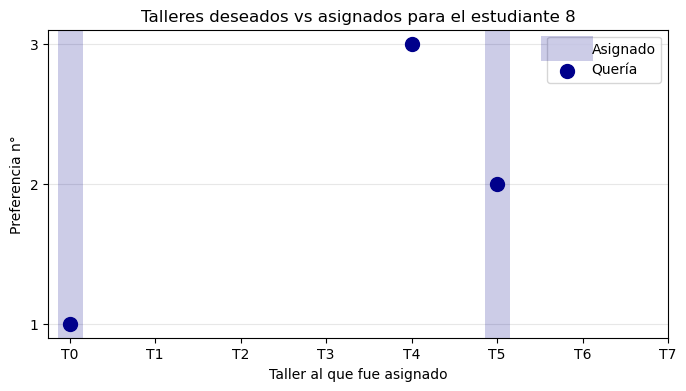

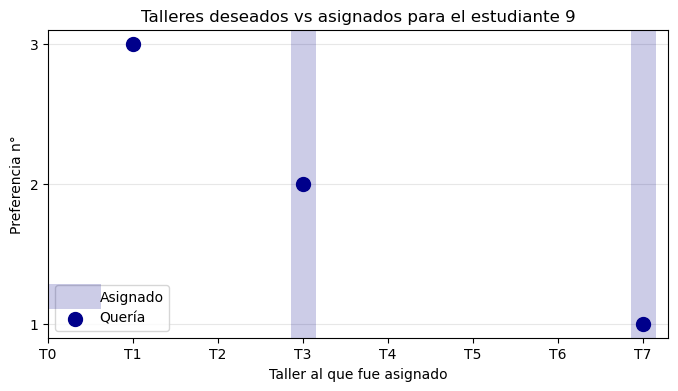

In [87]:
#visualizar la asignación de talleres
talleres = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
#para los estudiantes 0 al 9 muestra los talleres que quería y a los que fue asignado
for i in range(10):
    n_estudiante = i
    preferencias = util.get_dict(pref_m_aal, n_estudiante) #preferencia, taller
    asignados = dic_asignaciones_realizadas_mod[i] #asignaciones que se les dio, en mod
    
    plt.figure(figsize=(8, 4))
    #sombrear las columnas de los talleres asignados
    for t in asignados:
        plt.axvline(x=t, color='darkblue', alpha=0.2, linewidth=18, label='Asignado' if t == asignados[0] else "")
    
    #marcar los puntos de las preferencias
    for pref, t in preferencias.items():
        plt.scatter(t, pref, color='darkblue', s=100, zorder=3, label='Quería' if pref == 1 else "")
    
    plt.xticks(range(len(talleres)), talleres)
    plt.yticks(range(1, 4))
    plt.ylabel('Preferencia n°')
    plt.xlabel('Taller al que fue asignado')
    plt.title(f'Talleres deseados vs asignados para el estudiante {i}')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

# Estudiar por orden de llegada

Aca primero necesitaríamos alguna forma de seleccionar los talleres que se harían:

1. Hacer talleres con mayoría.
2. Probar combinaciones y elegir mejor: Hay 1575 formas de asignar

In [12]:
talleres_AM_realizar = [0, 1, 2, 3] 
talleres_PM_realizar = [4, 5, 6, 7] 

In [14]:
asignaciones = [[] for i in range(10)]

In [ ]:
def asignar(estudiante, asign, t_AM, t_PM):
    pref_1 = t_pref[estudiante][1]
    pref_1 = t_pref[estudiante][2]
    pref_1 = t_pref[estudiante][3]

In [ ]:
for j in S:
    

In [15]:
t_pref[0][1]

2